## Imports

In [1]:
# Standard library imports
import pickle

# Data analysis packages
import numpy as np

# Visualization packages
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import (
    SpikeData,
    read_phy_files,
    load_spike_data,
    burst_detection,
    randomize_raster,
)

## Helper Functions

In [2]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data["positions"].values():
        neuron_x.append(neuron["position"][0])
        neuron_y.append(neuron["position"][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions


def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)


def plot_raster(sd, title):
    idces, times = sd.idces_times()
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.scatter(times / 1000, idces, marker="|", s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("Unit #")
    ax.set_title(title)
    plt.show()


def unpickle_object(filename):
    """
    Deserializes and returns an object from a file using pickle

    Parameters:
    - filename: The name of the file from which the object will be loaded.

    Returns:
    - The Python object deserialized from the file.
    """
    with open(filename, "rb") as file:
        obj = pickle.load(file)
    return obj

## Plotting Function

In [3]:
def firing_plotter_with_raster(
    sd, title, global_min_rate, global_max_rate, time_windows
):
    colors = [
        "#ffcccb",
        "#ff6961",
        "#ff5c5c",
        "#ff1c00",
        "#bf0000",
        "#800000",
        "#400000",
        "#000000",
    ]
    cmap_name = "custom_red_black"
    n_bins = 100
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Window colors for the raster plot shading
    window_colors = ["#ffcccb", "#add8e6", "#77dd77", "#ffd700", "#fdbcb4"]

    # Adjust figure size and GridSpec layout to accommodate the new raster plot
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(
        3, 5, width_ratios=[1, 1, 1, 1, 0.05], height_ratios=[1, 0.8, 0.8]
    )
    fig.suptitle("Firing Rate by Time Window", fontsize=18)

    # Loop through time windows and plot firing rates
    for i, (start_time, end_time) in enumerate(time_windows):
        ax = plt.subplot(gs[0, i])
        current_sd = sd.subtime(start_time * 1000, end_time * 1000)
        firing_rates = calculate_mean_firing_rates(current_sd)
        neuron_x, neuron_y = [], []

        for neuron in current_sd.neuron_data["positions"].values():
            neuron_x.append(neuron["position"][0])
            neuron_y.append(neuron["position"][1])

        scatter = ax.scatter(
            neuron_x,
            neuron_y,
            s=firing_rates * 1.5,
            c=firing_rates,
            cmap=cm,
            vmin=global_min_rate,
            vmax=global_max_rate,
            alpha=0.6,
        )

        ax.set_title(f"{start_time}s to {end_time}s", fontsize=18)
        ax.set_xlabel("X Position", fontsize=14)
        if i == 0:
            ax.set_ylabel("Y Position", fontsize=14)
        else:
            ax.set_yticklabels([])

        ax.tick_params(axis="both", which="major", labelsize=12)
        ax.set_aspect("equal")
        ax.invert_yaxis()
        # ax.patch.set_edgecolor(window_colors[i % len(window_colors)])
        # ax.patch.set_linewidth(4)
        bottom_border_color = window_colors[i % len(window_colors)]
        ax.axhline(
            y=ax.get_ylim()[0], color=bottom_border_color, linewidth=7
        )

    # Determine the overall min and max times for the raster plot, in seconds
    overall_min_time = min(start for start, _ in time_windows)
    overall_max_time = max(end for _, end in time_windows)

    # Add the first raster plot beneath the subplots
    ax_raster = plt.subplot(gs[1, :-1])
    idces, times = sd.idces_times()
    ax_raster.scatter(times / 1000, idces, marker="|", s=1)
    ax_raster.set_xlabel("Time (seconds)", fontsize=14)
    ax_raster.set_ylabel("Unit #", fontsize=14)
    ax_raster.set_title("Zoomed Raster Plot", fontsize=18)
    ax_raster.tick_params(axis="both", which="major", labelsize=12)

    ax_raster.set_xlim(overall_min_time, overall_max_time)

    # Shade each time window section on the first raster plot with different colors
    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster.axvspan(start_time, end_time, color=color, alpha=0.3)

    # Add the second raster plot (full spikedata)
    ax_raster_full = plt.subplot(gs[2, :-1])
    ax_raster_full.scatter(times / 1000, idces, marker="|", s=1)
    ax_raster_full.set_xlim(0, sd.length / 1000)
    ax_raster_full.set_xlabel("Time (seconds)", fontsize=14)
    ax_raster_full.set_ylabel("Unit #", fontsize=14)
    ax_raster_full.set_title("Full Raster Plot", fontsize=18)
    ax_raster_full.tick_params(axis="both", which="major", labelsize=12)

    # Shade each time window section on the second raster plot with different colors
    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster_full.axvspan(start_time, end_time, color=color, alpha=0.3)

    # Setup colorbar axis to match only the height of the top row of firing rate plots
    cbar_ax = plt.subplot(gs[0, -1])
    cbar = fig.colorbar(scatter, cax=cbar_ax, label="Firing Rate (Hz)")
    cbar.set_label("Firing Rate (Hz)", size=14)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout(
        rect=[0, 0, 1, 0.95]
    )
    plt.savefig(f"figures/{title}_raster.png")
    plt.show()

## Data

In [4]:
random_spike_data = unpickle_object("data/random_spike_data.pkl")
linear_spike_data = unpickle_object("data/plane_wave_spike_data.pkl")
circular_spike_data = unpickle_object("data/ring_wave_spike_data.pkl")
continuous_loop_spike_data = unpickle_object("data/rotating_circle_spike_data.pkl")

## Plots

/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():
/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():
/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():


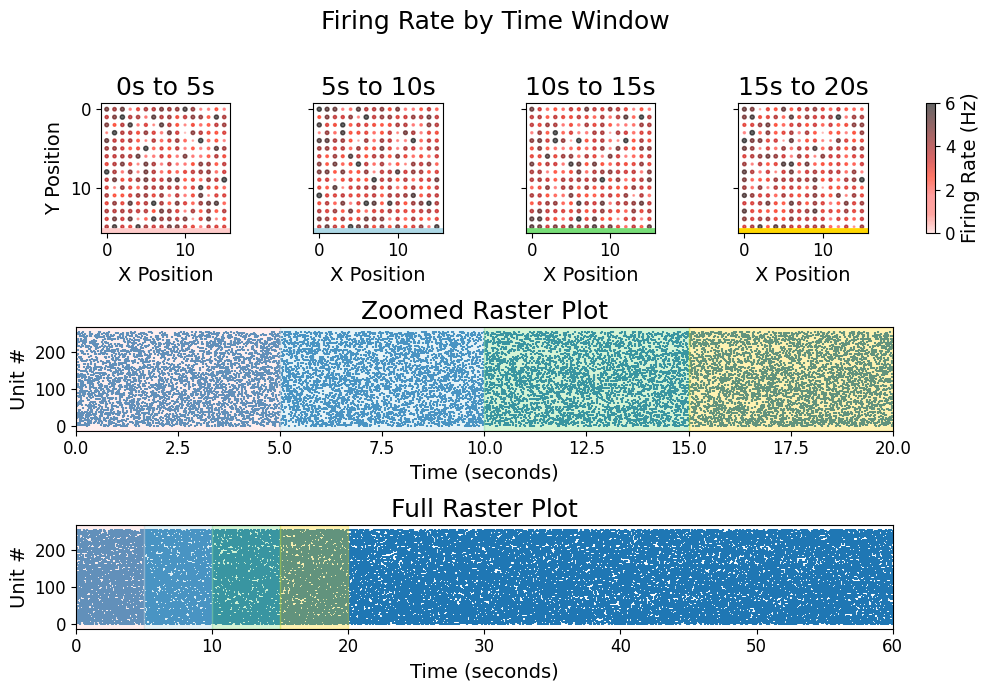

In [5]:
firing_plotter_with_raster(
    random_spike_data, "random", 0, 6, [(0, 5), (5, 10), (10, 15), (15, 20)]
)

/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():
/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():
/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():


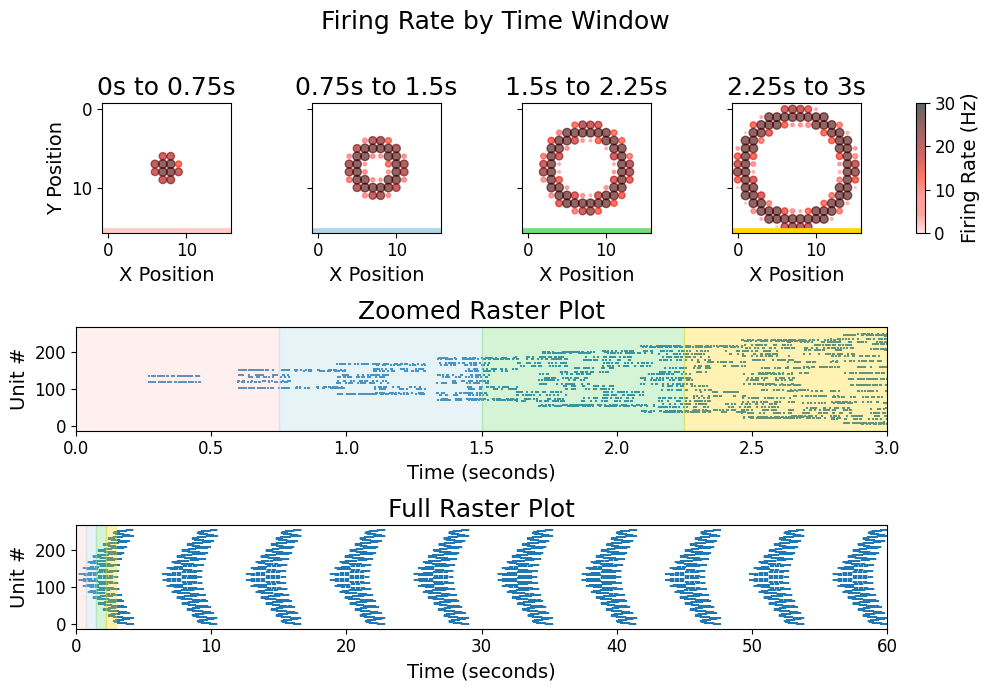

In [6]:
firing_plotter_with_raster(
    circular_spike_data, "ring", 0, 30, [(0, 0.75), (0.75, 1.5), (1.5, 2.25), (2.25, 3)]
)

/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():
/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():
/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():


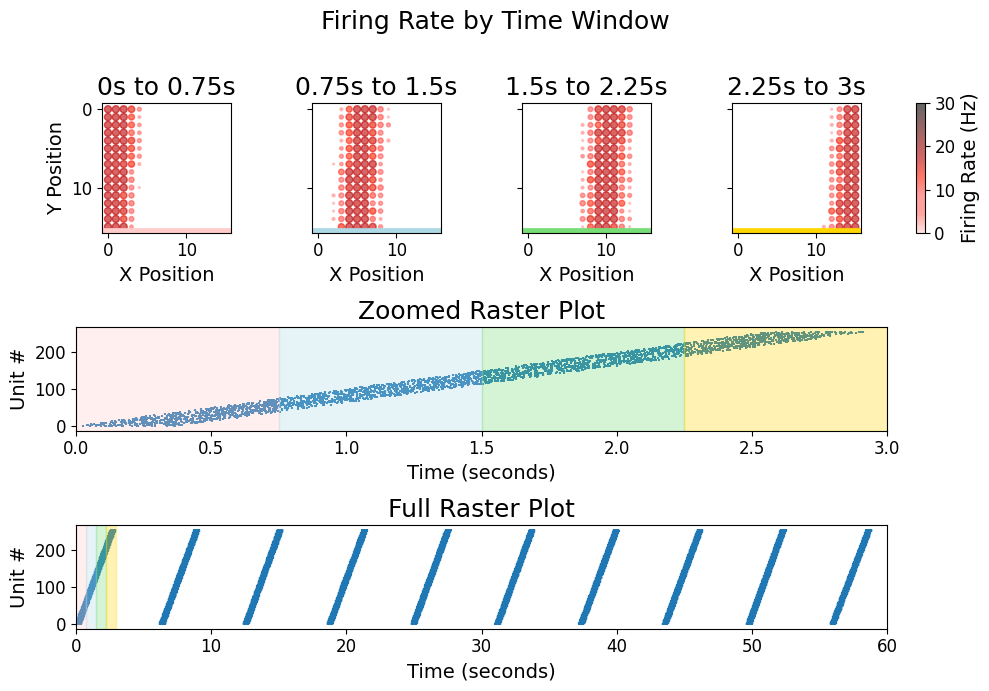

In [7]:
firing_plotter_with_raster(
    linear_spike_data, "plane", 0, 30, [(0, 0.75), (0.75, 1.5), (1.5, 2.25), (2.25, 3)]
)

/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():
/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():
/tmp/ipykernel_10923/2685359064.py:35: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data["positions"].values():


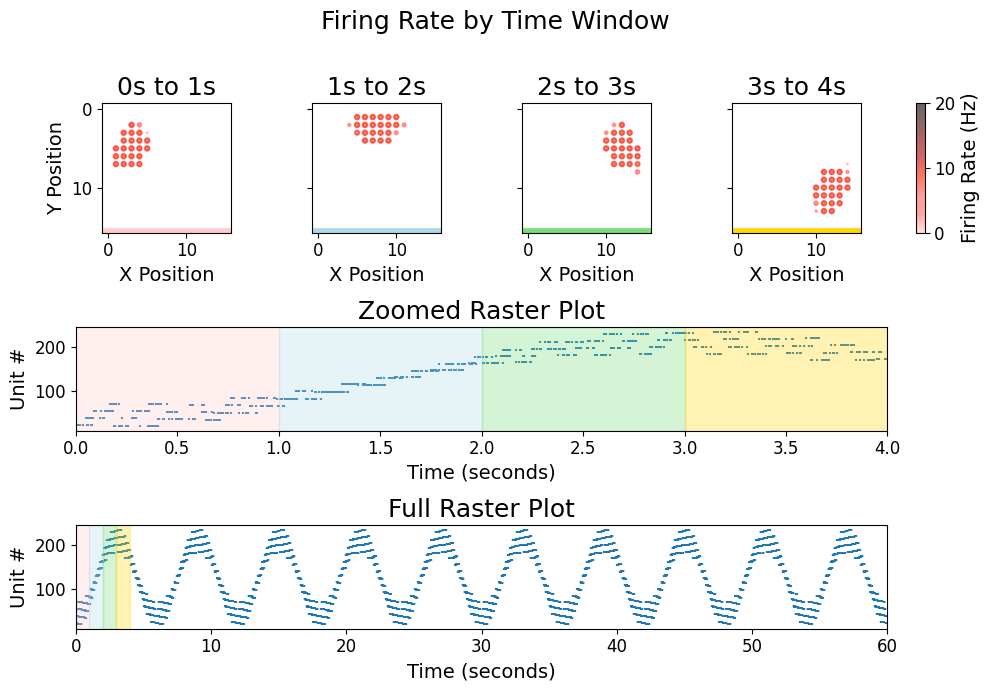

In [8]:
firing_plotter_with_raster(
    continuous_loop_spike_data, "loop", 0, 20, [(0, 1), (1, 2), (2, 3), (3, 4)]
)